# Aprendizaje Estadístico y Data Mining

## Práctica 1: Impacto de las restricciones de tráfico en la calidad del aire

### Objetivo
El 30 de diciembre de 2016 el Ayuntamiento de Madrid empieza a restringir el tráfico al centro de la ciudad
mediante la aplicación del escenario 3 del protocolo de contaminación. Esta fue la primera vez que se aplicó
un escenario tan restrictivo. Demuestra mediante visualizaciones de datos que ha ocurrido después de ello.
Para dicho problema, haremos uso de un dataset con datos sobre la calidad del aire en Madrid desde 2001. El
dataset contiene un archivo csv por año. Dentro de cada uno de ellos habrá medidas diarias de distintas
estaciones. Estas estaciones miden diferentes parámetros y no siempre todos se registran en cada una de las
estaciones.

* [Link al dataset.](https://www.kaggle.com/decide-soluciones/air-quality-madrid/downloads/csvs_per_year.zip/)

### Apartado 1

**Enunciado:** Cargar los archivos CSV en un único DataFrame, identificar y corregir posibles datos redundantes o anómalos, calcular la calidad del aire diario promediando los valores de las estaciones meteorológicas, estimar el primer valor según la tabla proporcionada, transformar los valores continuos a categóricos, almacenar la información en un DataFrame y guardarla en un archivo CSV, y finalmente determinar la calidad del aire general considerando el peor índice de las cinco partículas indicadas en la tabla.

<img src="./media/Enunciado%20Apartado%201.png" width="50%">

**Solución**

Cargamos los archivos CSV correspondientes a los datos de calidad del aire.

In [1]:
%reset
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import numpy as np
import seaborn as sns

ruta1_csvs = "data/csvs_per_year/csvs_per_year/"
ruta2_csvs = "data/stations.csv"

# Capturo todos los datos de Madrid desde 2001-2018 usando la librería glob para capturar los .csv
archivos_madrid_csv = glob.glob(os.path.join(ruta1_csvs, "*.csv"))

# Usando pandas, leemos y combinamos los archivos en un único Dataframe
df_madrid_sin_filtrar = pd.concat([pd.read_csv(archivo) for archivo in archivos_madrid_csv], ignore_index=True)

# Con el csv de stations, al ser uno solo, podemos leerlo y añadirlo directamente a otro Dataframe para diferenciar entre sets de datos.
df_stations = pd.read_csv(ruta2_csvs)

# Seleccionamos solo las columnas necesarias para medir la contaminación de cada día
columnas_necesarias = ['date', 'PM25', 'PM10', 'NO_2', 'O_3', 'SO_2', 'station']
# Declaramos también aquellas columnas que contienen únicamente las partículas necesarias para calcular la contaminación
columnas_calidad_aire = ['PM25', 'PM10', 'NO_2', 'O_3', 'SO_2']
# Filtramos el DataFrame para quedarnos solo con estas columnas
df_madrid = df_madrid_sin_filtrar[columnas_necesarias]

En primer lugar, verificaremos que porcentaje de datos nulos hay por columna, para decidir si borrarlas o mantenerlas.

In [2]:
# Visualizamos el porcentaje de valores nulos por cada columna
print("PORCENTAJE DE VALORES NULOS POR COLUMNA DEL DF MADRID")
print((df_madrid.isnull().sum() / (df_madrid.count() + df_madrid.isnull().sum())) * 100)

PORCENTAJE DE VALORES NULOS POR COLUMNA DEL DF MADRID
date        0.000000
PM25       78.561555
PM10       24.866421
NO_2        0.556007
O_3        21.440230
SO_2       27.106179
station     0.000000
dtype: float64


A continuación, nos deshacemos de aquellas filas duplicadas que puedan aparecer:

In [3]:
# Buscamos duplicados, y nos deshacemos de ellos para evitar redundancias
duplicados = df_madrid.duplicated().sum()
print("En este dataframe encontramos ", duplicados, " datos duplicados")
df_madrid = df_madrid.drop_duplicates()

En este dataframe encontramos  0  datos duplicados


Por último, habría que comprobar si existen datos recogidos de estaciones de las que no tengamos registro.

In [4]:
print("Estaciones en df que no están en df_stations:")
estaciones_sin_registro = set(df_madrid["station"]) - set(df_stations["id"])

# Eliminamos aquellas filas cuya estación no aparezca en nuestro df de estaciones
df_madrid = df_madrid[~df_madrid["station"].isin(estaciones_sin_registro)]

# Por último, nos cercioraremos de que los datos de fechas estén en el formato deseado.
df_madrid['date'] = pd.to_datetime(df_madrid['date'])

Estaciones en df que no están en df_stations:


Calcularemos la calidad del aire de cada día, agrupando los datos por fecha y estación, y obteniendo el peor dato de las 5 partículas para pasar el dato continuo a categórico.

In [5]:
df_calidad_diario = df_madrid
# Encontramos el peor valor (o el maximo) de las 5 partículas contaminantes,
# y guardamos en otra columna el valor y de que partícula se trata
df_calidad_diario['calidad_cuantitativa'] = df_calidad_diario[columnas_calidad_aire].max(axis=1)
df_calidad_diario['particula_maxima'] = df_calidad_diario[columnas_calidad_aire].idxmax(axis=1)

C:\Users\rmore\AppData\Local\Temp\ipykernel_18548\3187261602.py:5: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df_calidad_diario['particula_maxima'] = df_calidad_diario[columnas_calidad_aire].idxmax(axis=1)


Para categorizar, es decir, pasar de continuo a categórico, usaremos una función que podrá usar cualquier dataframe de aquí en adelante.

In [6]:
# Esta función añadirá un campo extra de "calidad categórica" cualquier dataframe que contenga los campos
# "calidad_cuantitativa" y "partícula_maxima", siguiendo la tabla del enunciado.
def categorizar(df):
    condiciones = [
    (df['particula_maxima'] == 'PM25'),
    (df['particula_maxima'] == 'PM10'),
    (df['particula_maxima'] == 'NO_2'),
    (df['particula_maxima'] == 'O_3'),
    (df['particula_maxima'] == 'SO_2')
    ]

    #Definimos las categorías con los rangos correspondientes a cada partícula
    categorias = [
        np.select([df['calidad_cuantitativa'] <= 15, df['calidad_cuantitativa'] <= 30, df['calidad_cuantitativa'] <= 55, df['calidad_cuantitativa'] <= 110],
                    ['Muy bueno', 'Bueno', 'Regular', 'Malo'], default='Muy malo'),
        np.select([df['calidad_cuantitativa'] <= 25, df['calidad_cuantitativa'] <= 50, df['calidad_cuantitativa'] <= 90, df['calidad_cuantitativa'] <= 180],
                    ['Muy bueno', 'Bueno', 'Regular', 'Malo'], default='Muy malo'),
        np.select([df['calidad_cuantitativa'] <= 50, df['calidad_cuantitativa'] <= 100, df['calidad_cuantitativa'] <= 200, df['calidad_cuantitativa'] <= 400],
                    ['Muy bueno', 'Bueno', 'Regular', 'Malo'], default='Muy malo'),
        np.select([df['calidad_cuantitativa'] <= 60, df['calidad_cuantitativa'] <= 120, df['calidad_cuantitativa'] <= 180, df['calidad_cuantitativa'] <= 240],
                    ['Muy bueno', 'Bueno', 'Regular', 'Malo'], default='Muy malo'),
        np.select([df['calidad_cuantitativa'] <= 50, df['calidad_cuantitativa'] <= 100, df['calidad_cuantitativa'] <= 350, df['calidad_cuantitativa'] <= 500],
                    ['Muy bueno', 'Bueno', 'Regular', 'Malo'], default='Muy malo')
    ]

    #Asignamos las categorías al dataframe basándonos en las condiciones, y en el caso de que no se cumpla ninguna condicion, asignamos el valor por defecti
    df['calidad_categorica'] = np.select(condiciones, categorias, default='Muy malo')

    return df

Una vez definida la función que categorizará nuestros dataframes, la aplicamos al dataframe que contendrá la calidad del aire de todos los datos proporcionados por los csv.

In [7]:
df_calidad_diario = categorizar(df_calidad_diario)

# Guardamos este dataframe en un csv, para analizarlo en caso de duda.
df_calidad_diario.to_csv('output\calidades_aire_diario.csv', index=False)

<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
C:\Users\rmore\AppData\Local\Temp\ipykernel_18548\1405334486.py:4: SyntaxWarning: invalid escape sequence '\c'
  df_calidad_diario.to_csv('output\calidades_aire_diario.csv', index=False)
C:\Users\rmore\AppData\Local\Temp\ipykernel_18548\1405334486.py:4: SyntaxWarning: invalid escape sequence '\c'
  df_calidad_diario.to_csv('output\calidades_aire_diario.csv', index=False)


KeyboardInterrupt: 

Una vez tenemos la partícula con mayor índice, comparamos entre estaciones que hayan recabado datos para cada día en concreto, para hallar la media de cada día.

In [ ]:
# Para ello, utilizaremos una función genérica, que será capaz de agrupar por x periodo (dias, meses, años, etc...)
#  y que encontrará la media para cada tipo de agrupación.
def calcular_medias_por_particula(df, contaminantes, periodo):
    #este df contendrá la concatenación de las medias de cada partícula por día
    df_medias_particulas = pd.DataFrame()

    for particula in contaminantes:
        #Este df obtendrá para cada (día, mes o año) la media para cada tipo de partícula, para no mezclar valores de distintas partículas
        df_particula = df[df["particula_maxima"] == particula]
        df_particula = df_particula.groupby(df_particula["date"].dt.to_period(periodo))["calidad_cuantitativa"].mean().reset_index()
        df_particula.loc[:, "particula_maxima"] = particula

        df_medias_particulas = pd.concat([df_medias_particulas, df_particula], ignore_index=True)

    # Una vez tenemos un df que contiene todas las medias de cada parícula para cada (día, mes o año), podemos sacar la media general,
    #  obteniendo la media más alta de entre las 5 partículas contaminantes.
    # De este modo, no mezclamos valores que pueden corresponder con categorías diferentes
    indices_maximos = df_medias_particulas.groupby("date")["calidad_cuantitativa"].idxmax()
    df_max = df_medias_particulas.loc[indices_maximos].reset_index(drop=True)

    return df_max

In [ ]:
# Agrupando por días, creamos un dataframe que tiene en cuenta todos los datos que hay para cada día y obtiene la media general
df_media_max_por_dia = calcular_medias_por_particula(df_calidad_diario, columnas_calidad_aire, "D")
df_media_max_por_dia = categorizar(df_media_max_por_dia)
df_media_max_por_dia = df_media_max_por_dia.rename(columns={
        "calidad_cuantitativa": "media_cuantitativa",
        "calidad_categorica": "media_categorica"
    })
df_media_max_por_dia.to_csv('output/medias_por_dia.csv', index=False)

### Apartado 2

**Enunciado:** Visualizar la distribución de la calidad del aire en las categorías buena, admisible, mala y muy mala mediante un gráfico de tipo pie chart. Analizar la representación obtenida y extraer conclusiones sobre la proporción de cada categoría en los datos.

**Solución**

Usaremos una función genérica para graficar pie charts dado un dataframe cualquiera.

In [ ]:
def graficar_pie_chart(df):
    # Comenzamos obteniendo los datos que se representarán en el gráfico, que dependerá de las categorías de calidades obtenidas
    secciones = df['media_categorica'].value_counts()

    # Asignamos colores reconocibles a cada categoría, y sus respectivas etiquetas
    colores = ["#AAF683","#60D394","#FFD97D","#FF9B85","#EE6055"]
    etiquetas = secciones.index
    if secciones.size == 4 :
        desfase = (0.05, 0.05, 0.07, 0.1)
    elif secciones.size == 3:
        desfase = (0.05, 0.05, 0.1)
    else:
        desfase = (0.05, 0.05, 0.07, 0.1, 0.1)

    # Con los datos del DataFrame de Calidades, graficamos el pie chart, asignándole un radio para obtener el pie chart deseado
    plt.figure(figsize=(8, 8))
    plt.pie(secciones, labels= etiquetas, autopct="%0.1f %%", colors=colores, explode=desfase)
    plt.axis('equal')
    plt.show()

Representaremos las distintas categorías de calidades de aire en un gráfico circular (pie chart). En este primer pie chart recogemos todos los datos disponibles desde 2001 hasta 2018, usando únicamente las medias categóricas de todas las calidades recogidas para cada día. En general, podemos observar como los datos son bastante positivos, resaltando que la calidad del aire "Muy mala" apenas llega al 0.01%.

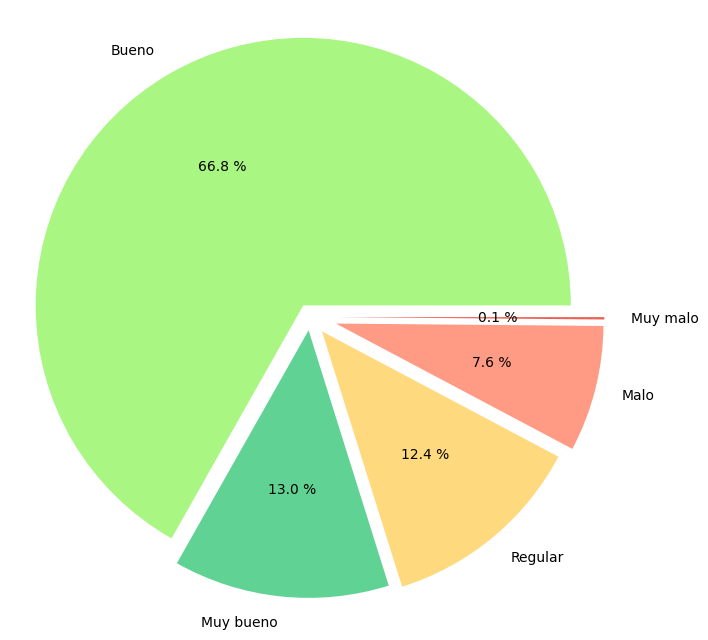

In [ ]:
graficar_pie_chart(df_media_max_por_dia)

Este pie chart muestra las calidades de aire medias por cada día que se registraron desde inicios de 2001 hasta principios del 2018. Son datos en los que destaca la presencia mayoritaria de las calidades "Muy buena" y "Buena", ya que rondan el 80% de todos los datos recogidos. Sin embargo, que en el 20% de los días se hayan registrado calidades del aire contaminantes puede explicar el porqué se implantaron estas medidas tan restrictivas. Antes de concluir nada, habría que cerciorarnos de cómo eran los datos antes y después del día en que se implantaron dichas medidas.

### Apartado 3

**Enunciado:** Calcular la calidad media del aire para cada mes con el objetivo de evaluar la evolución de la contaminación tras la restricción de acceso al centro de Madrid. Representar visualmente los resultados mediante un diagrama de barras para analizar el impacto de las restricciones de tráfico. Comparar los valores antes y después de la implementación del protocolo y determinar si se observa una mejora en la calidad del aire.

**Solución**

In [ ]:
# Renombramos estos dos campos para evitar conflictos a la hora de categorizar el futuro dataframe que obtendremos a partir de este.
df_media_max_por_dia = df_media_max_por_dia.rename(columns={
        "media_cuantitativa": "calidad_cuantitativa",
        "media_categorica": "calidad_categorica"
    })
# Debido a que la función que agrupa por x tipo de periodo solo acepta datos no convertidos a Datetime, convertimos el campo date a str para evitar conflictos
df_media_max_por_dia['date'] = df_media_max_por_dia['date'].astype(str).pipe(pd.to_datetime)

# Agrupando por meses, y reutilizando estas dos funciones principales, conseguimos obtener la media que se produjo en cada mes desde 2001 hasta 2018
df_media_max_por_mes = calcular_medias_por_particula(df_media_max_por_dia, columnas_calidad_aire, "M")
df_media_max_por_mes = categorizar(df_media_max_por_mes)

# Volvemos a renombrar, unicamente por cuestiones de estilo.
df_media_max_por_mes = df_media_max_por_mes.rename(columns={
        "calidad_cuantitativa":"media_cuantitativa",
        "calidad_categorica": "media_categorica"
    })
# Por último, guardamos los resultados en un csv nuevo.
df_media_max_por_mes.to_csv('output/medias_por_mes.csv', index=False)

Filtramos ahora desde enero 2001 hasta diciembre 2016, y desde diciembre 2016 hasta abril 2018, para conocer con mas exactitud si las medidas tuvieron repercusiones positivas o insignificantes. Usaremos diagramas de barras, para observar la proporción de las categorías de calidad a lo largo de esos meses.

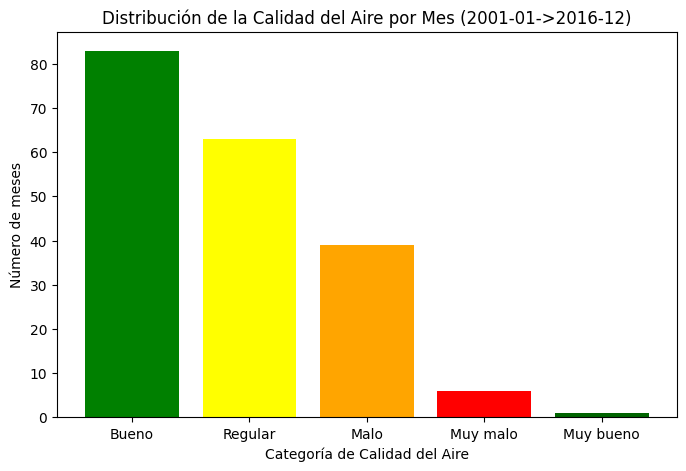

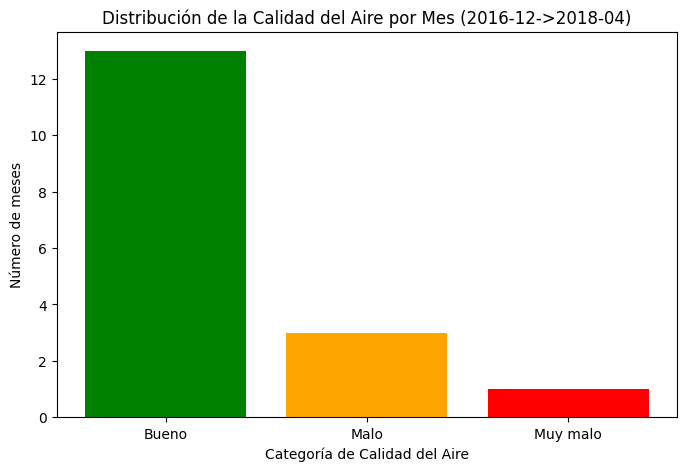

In [ ]:
# Esta función nos permitirá representar gráficos de barras que tomen distintas fechas de inicio y fechas finales.
def graficar_barras(df, fecha_inicio, fecha_final):
    df_periodo = df[(df['date'] >= fecha_inicio) & (df['date'] <= fecha_final)]
    categorias = df_periodo['media_categorica'].value_counts()

    # Para apreciar mejor las categorías, asignamos colores reconocibles a cada una de ellas.
    def color_barra(categoria):
        if categoria == 'Muy bueno':
            return "darkgreen"
        elif categoria == 'Bueno':
            return "green"
        elif categoria == 'Regular':
            return "yellow"
        elif categoria == 'Malo':
            return "orange"
        else: return "red"
    colores_barras = [color_barra(cat) for cat in categorias.index]

    # Graficar
    plt.figure(figsize=(8, 5))
    plt.bar(categorias.index, categorias.values, color=colores_barras)
    plt.xlabel("Categoría de Calidad del Aire")
    plt.ylabel("Número de meses")
    plt.title(f"Distribución de la Calidad del Aire por Mes ({fecha_inicio}->{fecha_final})")
    plt.show()

# Filtramos ahora desde 2001-01 hasta 2016-12, y desde 2016-12 hasta 2018-04
graficar_barras(df_media_max_por_mes, '2001-01', '2016-12')
graficar_barras(df_media_max_por_mes, '2016-12', '2018-04')

La mejoría es muy visible a primera vista. Los grafos, que muestran la cantidad de meses en las que cada categoría fue la media, muestran como las calidades negativas (Regular, Malo y Muy malo) disminuyen significativamente. Sin embargo, no parecen datos preocupantes los obtenidos en el periodo en el que madrid estuvo sin restricciones de acceso. Debemos tener en cuenta que en Madrid existen actualmente 1,4 millones de coches activos, lo que son aproximadamente 1.07 coches por vivienda. Además, para determinar si verdaderamente fueron necesarias dichas medidas, deberíamos tener en cuenta también la cantidad de coches que entran diariamente a Madrid Centro. 
Teniendo en cuenta únicamente los datos disponibles, podemos afirmar que si fueron beneficiosas para el medio ambiente, pero no es que hubiese un problema gravísimo de contaminación que pidiese la instauración de estas medidas tan extremas.

### Apartado 4

**Enunciado:** Generar un diagrama de cajas donde cada caja represente la calidad del aire en un año distinto para visualizar la evolución de la contaminación a lo largo del tiempo. Analizar la dispersión, los valores atípicos y la tendencia general de los datos, interpretando si ha habido mejoras o empeoramientos en la calidad del aire en los últimos años.

**Solución**

A partir del dataframe de medias de calidad por mes, contruimos un diagrama de cajas en el que cada cada agrupe la información de 12 meses, para poder ver los cambios de un año para otro.

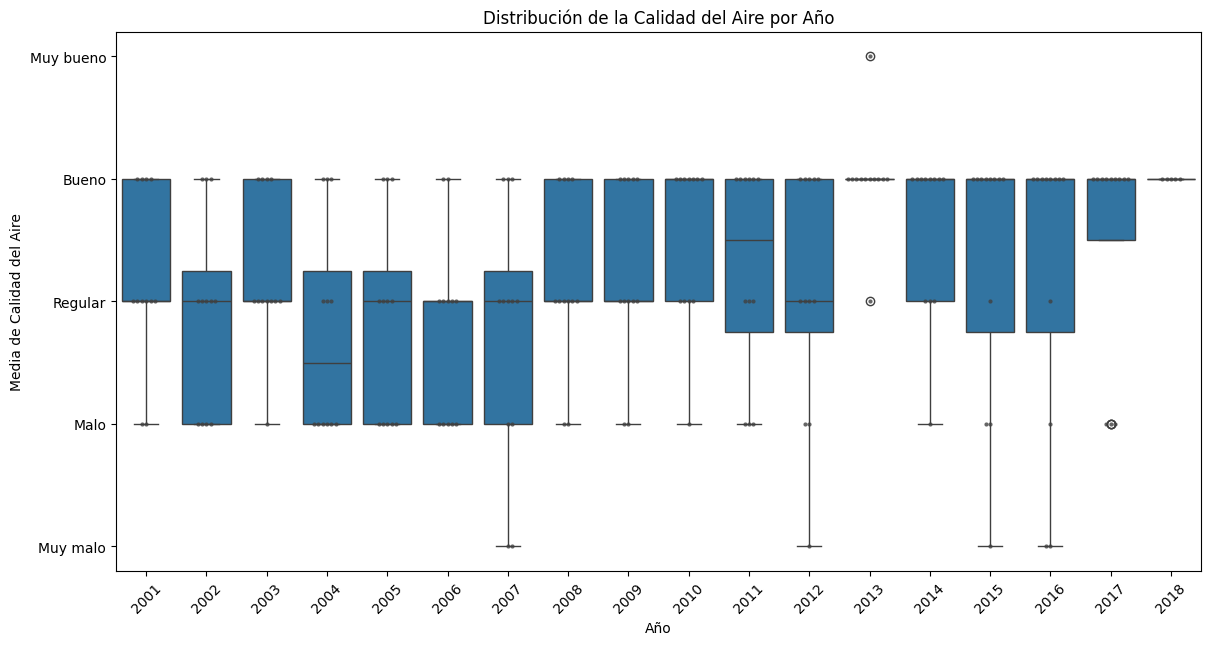

In [ ]:
def graficar_boxplot(df):
    # Creamos un boxplot que tenga en cuenta las medias categoricas por cada 12 meses, creando así una caja por año.
    # Para ello, necesitamos transformar de categórico a numérico, asignando un ranking de puntuación del 1-5.
    categorias_transformadas = {
    "Muy malo": 1,
    "Malo": 2,
    "Regular": 3,
    "Bueno": 4,
    "Muy bueno": 5
    }
    df["categoria_numerica"] = df["media_categorica"].map(categorias_transformadas)

    # Usando la libreria seaborn, creamos un boxplot simple, con un swarmplot que se superponga, para visualizar mejor los valores de cada mes, ya que son solo 12 por año y no abruman a la vista
    plt.figure(figsize=(14, 7))
    sns.boxplot(x="Año", y="categoria_numerica", data=df)
    sns.swarmplot(x="Año", y="categoria_numerica", data=df, size=3, color=".25", alpha=0.8)
    plt.title("Distribución de la Calidad del Aire por Año")
    plt.suptitle("")
    plt.xlabel("Año")
    plt.ylabel("Media de Calidad del Aire")
    # Para que los títulos roten automáticamente
    plt.xticks(rotation=45)
    plt.yticks(ticks=[1, 2, 3, 4, 5], labels=["Muy malo", "Malo", "Regular", "Bueno", "Muy bueno"])
    plt.show()

# Creamos una columna extra simplemente para facilitar que al graficar se muestren los años.
df_media_max_por_mes["Año"] = df_media_max_por_mes["date"].dt.year
graficar_boxplot(df_media_max_por_mes)

En el periodo anterior a las medidas de acceso, los datos oscilaban en un rango bastante grande, aunque cabe decir que seguían siendo valores bastante "poco contaminantes". En 2006 Madrid experienció la contaminación alta, ya que la mayoría de las categorías se encontraban entre Regular y Malo, pero aún así, se esperó hasta 2016 para implantar las medidas. Los valores obtenidos después del 30/12/2016 oscilan en un rango mucho menor, sobre todo si comparamos el año 2017 con los demás. Indica que las medidas surtieron efecto positivo, pero que nunca han sido del todo necesarias teniendo como referencia las buenas medias de calidad de aire entre los años 2001 y 2016. De hecho, antes del año de la instauración de las medidas (2008 - 2016), los datos eran bastante optimistas, lo que pone en duda si alguna vez fueron necesarias de verdad.
No hay más que echar un ojo a un artículo de Septiembre 2024, donde se publicó que la Justicia tumbó las medidas de bajas emisiones de Madrid Centro a petición de Vox. son datos que confirman la teoría que acabamos de elaborar.

### 5. Bibliografía

- Código para tratar valores nulos: 
  https://es.stackoverflow.com/questions/279443/c%C3%B3mo-calcular-el-recuento-de-datos-faltantes-para-columnas
- Código para generar un pie chart personalizado: 
  https://numython.github.io/posts/graficas-de-pastel-con-matplotlib/
- Código para generar un boxplot con el swarmplot combinado: 
  https://www.datacamp.com/es/tutorial/python-boxplots?dc_referrer=https%3A%2F%2Fwww.google.com%2F
- Artículo sobre la intensidad de tráfico en Madrid: 
  https://www.comunidad.madrid/servicios/transporte/estudio-intensidad-media-diaria-vehiculos-imd https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=4a2e4207bb864410VgnVCM1000000b205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD
- Artículo "La justicia tumba las zonas de bajas emisiones de Madrid a petición de VOX": 
  https://climatica.coop/justicia-anula-zonas-bajas-emisiones-madrid/